# Review: computer vision transfer learning

This is a subset of lesson 1 of https://course.fast.ai

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate

In [2]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%.

In [3]:
path = untar_data(URLs.PETS)
path_anno = path/'annotations'
path_img = path/'images'
np.random.seed(2)
fnames = get_image_files(path_img)
fnames[0]

PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Siamese_87.jpg')

In [15]:
(path/'annotations').ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/trainval.txt'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/test.txt'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/xmls'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/README'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/list.txt'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/._trimaps'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps')]

In [23]:
p = path/'annotations/README'
! cat $p

OXFORD-IIIT PET Dataset
-----------------------
Omkar M Parkhi, Andrea Vedaldi, Andrew Zisserman and C. V. Jawahar

We have created a 37 category pet dataset with roughly 200 images for each class. 
The images have a large variations in scale, pose and lighting. All images have an 
associated ground truth annotation of breed, head ROI, and pixel
level trimap segmentation.

Contents:
--------
trimaps/ 	Trimap annotations for every image in the dataset
		Pixel Annotations: 1: Foreground 2:Background 3: Not classified
xmls/		Head bounding box annotations in PASCAL VOC Format

list.txt	Combined list of all images in the dataset
		Each entry in the file is of following nature:
		Image CLASS-ID SPECIES BREED ID
		ID: 1:37 Class ids
		SPECIES: 1:Cat 2:Dog
		BREED ID: 1-25:Cat 1:12:Dog
		All images with 1st letter as captial are cat images while
		images with small first letter are dog images.
trainval.txt	Files describing splits used in the paper.However,
test.txt	you are encouraged to try ra

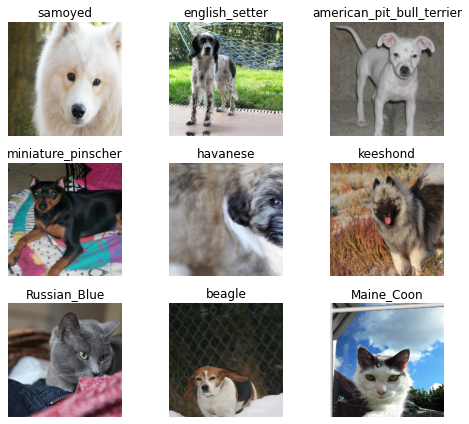

In [24]:
pat = r'/([^/]+)_\d+.jpg$'
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(7,6))

## Training

In [25]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 60.0MB/s]


In [26]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.365831,0.329426,0.112991,00:28
1,0.644737,0.319994,0.098106,00:27
2,0.376254,0.232905,0.075778,00:26
3,0.280889,0.220775,0.074425,00:28


In [27]:
learn.save('stage-1')

In [28]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.245525,0.209468,0.068336,00:30
1,0.213979,0.205220,0.066982,00:30


In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Egyptian_Mau', 'Bengal', 5),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Maine_Coon', 'Bengal', 3),
 ('Siamese', 'Birman', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('Abyssinian', 'Egyptian_Mau', 2),
 ('Bengal', 'Abyssinian', 2),
 ('boxer', 'american_bulldog', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('german_shorthaired', 'american_pit_bull_terrier', 2),
 ('keeshond', 'leonberger', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2)]